In [1]:
import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import jax.random as jr
import matplotlib.pyplot as plt

In [11]:
class Generator(eqx.Module):
    linear_layer: eqx.nn.Linear
    downsample_layers_01: list

    def __init__(self, latent_size, key: jr.PRNGKey):
        keys = jr.split(key, 6)  # Precisamos de 6 chaves, uma para cada camada

        # Primeiro, transforma o vetor latente em um tensor que pode ser processado por camadas convolucionais
        self.linear_layer = eqx.nn.Linear(in_features=latent_size, out_features=512 * 1 * 1, key=keys[0])

        self.downsample_layers_01 = [
            eqx.nn.BatchNorm(input_size=512, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            # Upsampling progressivo
            eqx.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=256, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[2]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[3]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[4]),
            eqx.nn.BatchNorm(input_size=32, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            
            eqx.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[5]),
            eqx.nn.BatchNorm(input_size=16, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[6]),
            jax.nn.tanh  # Gera uma imagem com valores de pixel no intervalo [-1, 1]
        ]

    def __call__(self, x, state):
        x = self.linear_layer(x)
        x = x.reshape(x.shape[0], 1, 1)  # Redimensiona para a forma desejada para convolução
        print(x.shape)
        
        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)
            print(x.shape)
        
            
        return x, state


(100, 100)
(512, 1, 1)
(512, 1, 1)
(512, 1, 1)
(256, 2, 2)
(256, 2, 2)
(256, 2, 2)
(128, 4, 4)
(128, 4, 4)
(128, 4, 4)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(32, 16, 16)
(32, 16, 16)
(32, 16, 16)
(16, 32, 32)
(16, 32, 32)
(16, 32, 32)
(1, 64, 64)
(1, 64, 64)
-0.9341284
0.77789843


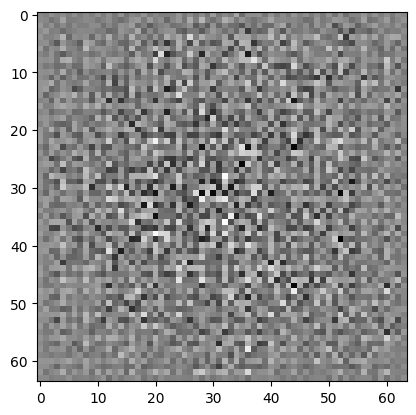

In [13]:
key = jr.PRNGKey(1)
latent_size = 100

generator, state = eqx.nn.make_with_state(Generator)(latent_size, key)

test_tensor = jr.normal(key, (100, latent_size))

print(test_tensor.shape)

output, state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

images = output
print(images.min())
print(images.max())
images = (images - images.min()) / (images.max() - images.min())
plt.imshow(images[0, 0], cmap='gray')
plt.show()



In [4]:
class Discriminator(eqx.Module):
    downsample_layers_01: list
    linear_layer: eqx.nn.Linear

    def __init__(self, key: jr.PRNGKey):
        keys = jr.split(key, 6)
        #64x64x1
        self.downsample_layers_01 = [
            eqx.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[0]),
            jax.nn.leaky_relu,
            
            eqx.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[2]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[3]),
            eqx.nn.BatchNorm(input_size=256, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0, use_bias=False, key=keys[4]),
        ]

        self.linear_layer = eqx.nn.Linear(in_features=512, out_features=1, key=keys[5])
        
    def __call__(self, x, state):
        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)
            print(x.shape)

        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        print(x.shape)
        x = self.linear_layer(x)  # Linear layer for classification
        print(x.shape)
        return x, state
        

In [5]:
seed = 2
key = jr.PRNGKey(seed)
mkey, xkey, xkey2 = jr.split(key, 3)
input_shape = (64, 64, 1)

#Inicia o modelo e o estado com as variaveis que foram definidas no Init
discriminator, state = eqx.nn.make_with_state(Discriminator)(key)

test_tensor = jr.normal(xkey, (5, 1, 64, 64))

output, state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

images = output


print(output)


(32, 32, 32)
(32, 32, 32)
(64, 16, 16)
(64, 16, 16)
(64, 16, 16)
(128, 8, 8)
(128, 8, 8)
(128, 8, 8)
(256, 4, 4)
(256, 4, 4)
(256, 4, 4)
(512, 1, 1)
(512, 1)
(1, 1)
[[[ 0.1067538 ]]

 [[-0.09251871]]

 [[-0.02699584]]

 [[-0.34522945]]

 [[ 0.24075383]]]
